In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load, load_acsincome, load_compas
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'german_influence.ipynb', 'german_influence_copy.ipynb', 'influence.py', 'load_dataset.py', 'loss.py', 'metrics.py', 'random_influence.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


In [3]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('income')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['income'] = changed_df_labels

    return y_predicted


<h4>Removal Based Influence Calculation<h4>

In [4]:
#List of time taken
sol_time = []

In [5]:
dataset = 'adult'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [6]:
X_train, X_test, y_train, y_test = load(dataset)

In [7]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [8]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
predictors = ['age', 'workclass', 'education', 'marital', 'relationship', 'race',
       'gender', 'hours']
target_var = ['income']

In [10]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [11]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [12]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.18768421394471035
Initial TPR parity:  -0.15846309128017155
Initial predictive parity:  -0.21193522369352036
Initial accuracy:  0.8051128818061088


<h5>INF Calc on Original Labels for Leave one Out<h5>

In [13]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [14]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 30162/30162 [01:11<00:00, 419.68it/s]


In [15]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [16]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [17]:
#multiple the inverse by -1
negative_hinv_v = -1 * hinv_v

In [18]:
inf = np.matmul(np.transpose(negative_hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [19]:
inf = (-1/(len(X_train))) * inf

In [20]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]

<h5>Leave One out Trainng<h5>

In [21]:
#Removal using leave one out concept
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

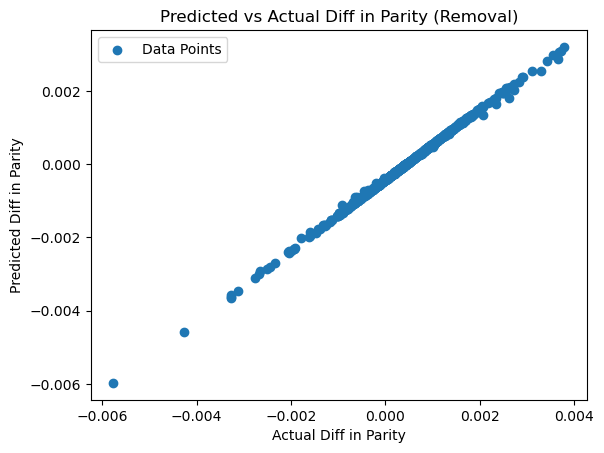

In [ ]:
predicted_diff = decimal_array
#actual_diff = actual_parity_list
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (LOO)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>INF calc on flipped labels and compare them to flipping the datapoints<h3>

In [17]:
flipping_time_start = time.time()
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})

In [18]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [19]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_1)

predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_1)

accuracy_1 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_1)

Initial statistical parity:  0.1872713347967041
Initial TPR parity:  0.15826518675482348
Initial predictive parity:  -0.1451967570847148
Initial accuracy:  0.1948207171314741


In [20]:
#if_start = time.time()
metric_val = [spd_1, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta2 = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [21]:
hessian_all_points2 = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 30162/30162 [02:49<00:00, 177.92it/s]


In [22]:
del_L_del_theta2 = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [23]:
hinv_v2, hinv2 = get_hinv_v(hessian_all_points2, np.transpose(del_L_del_theta2))
#incorporate del_l_del_theta_i with the updated datapoint

In [ ]:
#Get the negative of the inverse hessian
negative_hinv_v_2 = -1*hinv_v2

In [24]:
inf2 = np.matmul(np.transpose(negative_hinv_v_2), del_F_del_theta2)
#For the new datapoint re-calculate the hinv_v

In [ ]:
inf2 = (-1/(len(X_train))) * inf2

In [ ]:
#Flipping
#Make the original flips to test for the parity after each flip 
actual_df_train = train_full_df.copy()
actual_parity_list = []

for index, row in actual_df_train.iterrows():
    if row['income'] == 1:
        #Flip the label at income = 1 to 0
        actual_df_train.at[index,'income'] = 0
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'income'] = 1
        
    elif row['income'] == 0:
        actual_df_train.at[index,'income'] = 1
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'income'] = 0

In [ ]:
decimal_array = [format(num, '.10f') for num in inf2]
decimal_array = [float(num) for num in decimal_array]

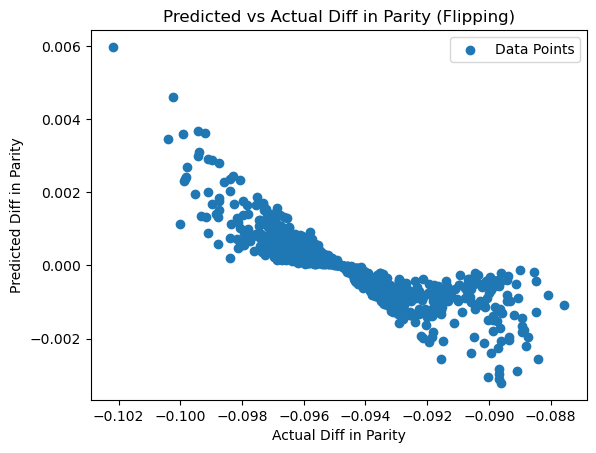

In [ ]:
predicted_diff = decimal_array
actual_diff = actual_parity_list

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<h5>Implement Solutions<h5>
<li>Influence</li>
<li>Entropy</li>
<li>Randomized</li>


<h5>Influence Based Flips<h5>

In [40]:
if_start = time.time()
index_list = []
for i in range(len(X_train)):
    index_list.append(i)

In [41]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [42]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(inf2, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
flipping_time_end = time.time() - flipping_time_start

print(flipping_time_end)

-192.40969038009644


In [43]:
if flipping_time_end < 0:
    flipping_time_end = -1 * flipping_time_end
else: 
    pass

In [44]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'income'] == 1:
        influence_train_copy.at[row_num,'income'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'income'] == 0:
        influence_train_copy.at[row_num,'income'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)

KeyboardInterrupt: 

In [41]:
sol_time.append(flipping_time_end)

<h5>Uncertainty Reduction/Entropy<h5>

In [42]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [43]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

80.3253652058433


In [44]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [45]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [46]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time()

In [47]:
entropy_train_df['income'] = entropy_train_df['income'].astype('int')

In [48]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [49]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'income'] == 0:
        entropy_train_df.at[row_num,'income'] = 1
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'income'] == 1:
        entropy_train_df.at[row_num,'income'] = 0
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [50]:
entropy_time = entropy_end - entropy_start
sol_time.append(entropy_time)

<h5>Randomized<h5>

In [51]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [54]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = len(y_test)

for iter in range(budget):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'income'] == 1:
        random_training_df.at[random_row,'income'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'income'] == 0:
        random_training_df.at[random_row,'income'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()


In [55]:
random_time = random_end - random_start
sol_time.append(random_time)

<h5>Graph Time and Parity<h5>

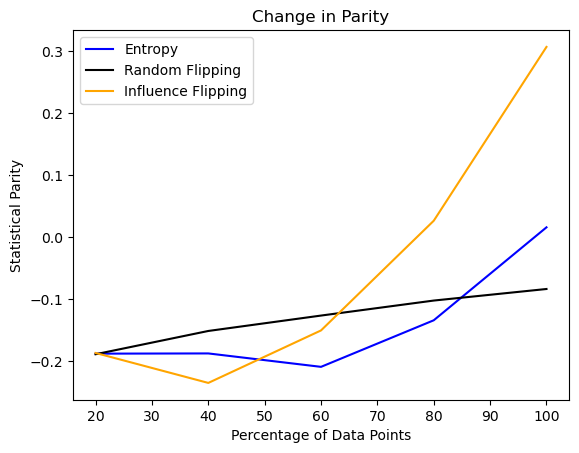

In [56]:
# Calculate the total number of data points
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]
indices_influence = [int(i * datapoints_influence / 5) for i in range(0, 5)]

# Extract the values at these indices
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Black')
plt.plot([20, 40, 60, 80, 100], values_influence, label='Influence Flipping', color='Orange')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()

<h4>Time Comparisons<h4>

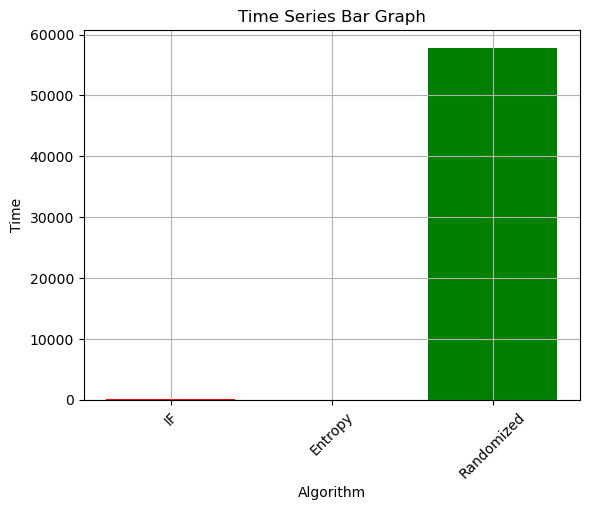

In [57]:
# Create a line chart
x_axis = ['IF', 'Entropy', 'Randomized']
# Colors for each bar
colors = ['red', 'blue', 'green']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Series Bar Graph')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [58]:
print(predicted_diff)
print(actual_diff)

[-7.3657e-06, -4.25494e-05, -7.701e-06, -2.54641e-05, 4.44951e-05, 7.03888e-05, 1.46136e-05, 3.8096e-05, -0.0001039016, 4.55864e-05, 4.43842e-05, 4.07307e-05, 1.68768e-05, -1.28806e-05, -2.34915e-05, -5.188e-06, -5.0774e-06, -3.79886e-05, -8.77454e-05, 2.01961e-05, 2.08087e-05, -1.69753e-05, -2.41183e-05, 2.27185e-05, 3.36076e-05, -5.0774e-06, -1.39438e-05, -3.59582e-05, -1.66871e-05, -8.8871e-06, -1.25604e-05, -1.3664e-05, -3.07785e-05, -4.9933e-06, -5.8382e-06, 3.63136e-05, -4.81123e-05, -3.08042e-05, -4.25494e-05, -5.25837e-05, 2.27185e-05, -5.0774e-06, 3.48356e-05, -3.59582e-05, 4.13188e-05, -4.7222e-05, -1.74589e-05, 3.91678e-05, -4.11616e-05, 3.69542e-05, -1.80656e-05, 4.97704e-05, -1.86334e-05, -4.54864e-05, -4.54214e-05, -3.00483e-05, -3.6334e-05, -3.59582e-05, 2.01961e-05, -1.57587e-05, -3.00483e-05, 1.94224e-05, -7.50388e-05, 3.28975e-05, -5.8382e-06, 2.08903e-05, 3.81174e-05, -5.8382e-06, -1.60914e-05, -5.0774e-06, -4.25489e-05, 8.5099e-06, -1.80784e-05, -5.0774e-06, -4.2133